In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.nn as nn

### Creating the model

In [33]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [34]:
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-08 00:04:13--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  84.9MB/s    in 3.9s    

2021-03-08 00:04:17 (86.3 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [35]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

### Downloading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
try:
  !rm oxbuild_images.tgz
except:
  print("Does not exist")

rm: cannot remove 'oxbuild_images.tgz': No such file or directory


In [9]:
!mkdir oxbuild_images

In [10]:
#!rm -rf oxbuild_images.tgz

In [12]:
cd oxbuild_images/

/content/gdrive/My Drive/oxbuild_images


In [14]:
!wget https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz
!unzip oxbuild_images.tgz

--2021-03-07 23:58:42--  https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1980280437 (1.8G) [application/x-gzip]
Saving to: ‘oxbuild_images.tgz’

oxbuild_images.tgz  100%[===================>]   1.84G  33.9MB/s    in 56s     

2021-03-07 23:59:39 (33.6 MB/s) - ‘oxbuild_images.tgz’ saved [1980280437/1980280437]

Archive:  oxbuild_images.tgz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of oxbuild_images.tgz or
        oxbuild_images.tgz.zip, and cannot find oxbuild_images.tgz.ZIP, period.


In [15]:
!tar -zxvf oxbuild_images.tgz 
!rm oxbuild_images.tgz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
all_souls_000093.jpg
all_souls_000095.jpg
all_souls_000097.jpg
all_souls_000099.jpg
all_souls_000100.jpg
all_souls_000101.jpg
all_souls_000102.jpg
all_souls_000103.jpg
all_souls_000105.jpg
all_souls_000106.jpg
all_souls_000107.jpg
all_souls_000110.jpg
all_souls_000114.jpg
all_souls_000117.jpg
all_souls_000119.jpg
all_souls_000120.jpg
all_souls_000126.jpg
all_souls_000130.jpg
all_souls_000131.jpg
all_souls_000132.jpg
all_souls_000133.jpg
all_souls_000134.jpg
all_souls_000136.jpg
all_souls_000140.jpg
all_souls_000142.jpg
all_souls_000143.jpg
all_souls_000144.jpg
all_souls_000145.jpg
all_souls_000146.jpg
all_souls_000148.jpg
all_souls_000149.jpg
all_souls_000150.jpg
all_souls_000151.jpg
all_souls_000152.jpg
all_souls_000153.jpg
all_souls_000157.jpg
all_souls_000159.jpg
all_souls_000160.jpg
all_souls_000161.jpg
all_souls_000162.jpg
all_souls_000167.jpg
all_souls_000174.jpg
all_souls_000175.jpg
all_souls_000176.jp

### Loading dataset

In [16]:
from torchvision import datasets
import sys, os
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import cv2
from PIL import Image
from numpy import asarray

def dataload(path1,  size = (224, 224, 3)):
    """
    inputs: path to images folder
    returns: arrays contains imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1], size[2]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
      img_path = path1 + "/" + img_name
      img = np.array(Image.open(img_path, mode="r").resize((size[0], size[1], size[2])))
      visible[i] = img 
    print("\t############# All VISIBLE images to array ##########")
    return visible

def dataLabels(path1):
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]

    labels = []
    for img_name in tqdm(onlyfiles1):
        labels.append(img_name)

    return labels

In [17]:
cd ..

/content/gdrive/My Drive


In [18]:
main_path = os.path.abspath(os.getcwd())
data_dir = main_path + '/oxbuild_images/'
print(data_dir)

/content/gdrive/My Drive/oxbuild_images/


In [19]:
!mv  oxbuild_images train
!mkdir oxbuild_images
!mv train oxbuild_images
!cd oxbuild_images

In [20]:
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/oxbuild_images/", transform=preprocess)

In [21]:
dsets

Dataset ImageFolder
    Number of datapoints: 5063
    Root location: /content/gdrive/My Drive/oxbuild_images/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [22]:
labels = dataLabels("/content/gdrive/My Drive/oxbuild_images/train/")

100%|██████████| 5063/5063 [00:00<00:00, 1293443.85it/s]


In [23]:
labels[:10]

['all_souls_000000.jpg',
 'all_souls_000001.jpg',
 'all_souls_000002.jpg',
 'all_souls_000003.jpg',
 'all_souls_000005.jpg',
 'all_souls_000006.jpg',
 'all_souls_000007.jpg',
 'all_souls_000008.jpg',
 'all_souls_000010.jpg',
 'all_souls_000011.jpg']

In [24]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

### Loading Model

In [25]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [26]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
device

'cuda'

### Image Ranking using Max-Pooling

In [36]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

In [37]:
class MyModel(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel, self).__init__()
    #self.get_features = torch.nn.Sequential(*(list(model.visual.children())[:1]))
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)
    logit = self.pooling(out)
    #logit /= torch.sum(logit)
    return logit

In [38]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

In [39]:
print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [40]:
conv = MyModel(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)
#conv = nn.Conv2d(in_channels=3, out_channels=vision_width, kernel_size=vision_patch_size, stride=vision_patch_size, bias=False)
print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [41]:
images, labels = next(iter(data_loader))
print("Images shape: ", images.shape)

Images shape:  torch.Size([16, 3, 224, 224])


In [42]:
img = images[0].unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


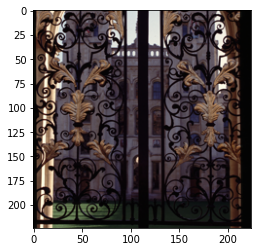

In [43]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

In [44]:
conv = conv.eval()
print(img.dtype)
target_img = conv(img)
target_img.shape

torch.float32


torch.Size([1, 768, 1, 1])

In [45]:
#Normalize features extracted
#target_img_norm = torch.norm(target_img, p=2.0, dim=1, keepdim=True)
target_img_norm = target_img / (torch.norm(target_img, p=2, dim=1, keepdim=True) + 1e-12).expand_as(target_img)
print(target_img_norm.shape)

torch.Size([1, 768, 1, 1])


In [46]:
def preconvfeat(dataloader):
    conv_features, normalized = [], []
    imgs = []
    for data in dataloader:
        input, label = data
        with torch.no_grad():
          for i in range(input.shape[0]):
            img = input[i].to(device)
            img = img.unsqueeze(0)
            x = conv(img)
            imgs.append(img)
            #Normalize features
            #x_norm = torch.nn.functional.normalize(x, p=2.0, dim=1)
            x_norm = x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-12).expand_as(x)
            conv_features.append(x.cpu().detach().numpy())
            normalized.append(x_norm.cpu().detach().numpy())
    
    return normalized, conv_features, imgs

In [47]:
conv = conv.to(device)
normalized, features, images = preconvfeat(data_loader)

In [48]:
print("features for img0: ", features[0].shape)
print("normalized for img0: ", normalized[0].shape)

features for img0:  (1, 768, 1, 1)
normalized for img0:  (1, 768, 1, 1)


In [49]:
def calculate_distances(target, targetID, conv_features, nbr = 5):
  distances = []
  for i, img_conv in enumerate(conv_features):
    distance = np.linalg.norm(target.cpu().detach().numpy() - img_conv)
    if i != targetID: 
      distances.append(distance)

  indices = np.argsort(distances)[:nbr]
  return distances, indices

In [50]:
print("Length of Features: ", len(features))
print("Each feature shape: ", features[0].shape)

print("Dataset images: ", len(images))
print("Image shape: ", images[0].shape)

Length of Features:  5063
Each feature shape:  (1, 768, 1, 1)
Dataset images:  5063
Image shape:  torch.Size([1, 3, 224, 224])


#### Without normalization

In [51]:
dist, indices = calculate_distances(target_img, 0, features)

In [52]:
print("Distances:" , np.sort(dist[:5]))
print("Indices: ", indices)

Distances: [11.509332  12.491071  12.8996725 13.856352  14.62314  ]
Indices:  [ 734 3614 2617 3137 1672]


In [53]:
def get_similar(images, indices):
  ret_imgs = []
  for i, value in enumerate(indices):
    ret_imgs.append(images[value])
  return ret_imgs

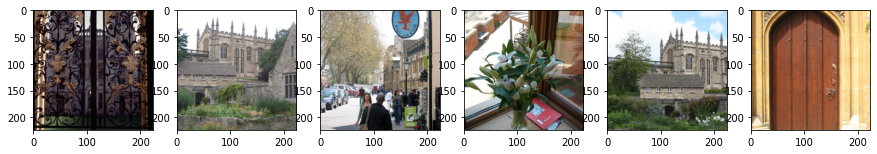

In [54]:
ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(img[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())


In [55]:
def generate_samples(dataset, nbr = 5):
  random_imgs = np.random.randint(0, 1500, nbr)
  samples = []

  for i in random_imgs:
    samples.append(dataset[i][0].unsqueeze(0))
  return samples, random_imgs

samples, ind = generate_samples(dsets, 5)

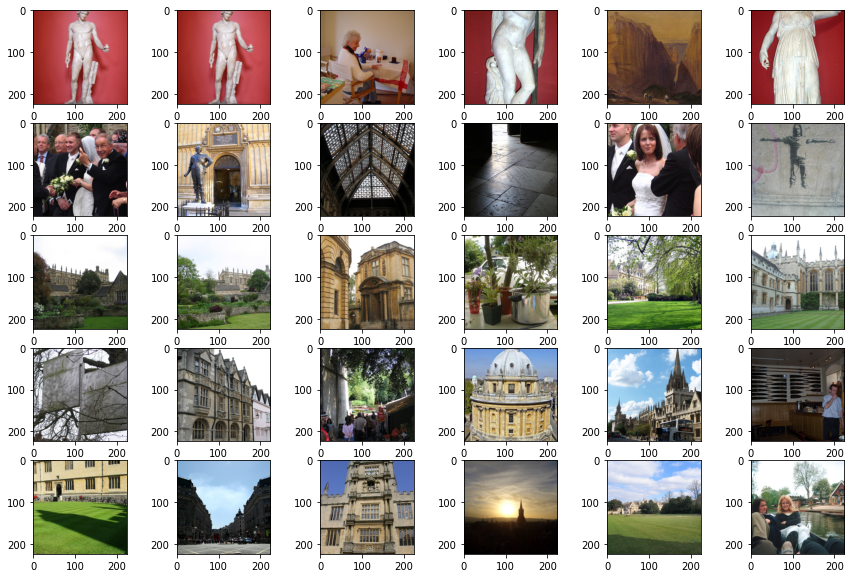

In [57]:
fix, ax = plt.subplots(5, 6, figsize=(15, 10))

for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  conv = conv.to(device)
  target_img = conv(samples[i].to(device))
  targetID = ind[i]
  dist, indices = calculate_distances(target_img, targetID, features)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())

### With L2 normalization

In [58]:
dist, indices = calculate_distances(target_img_norm, 0, normalized)

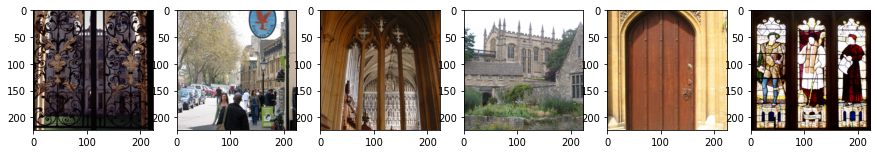

In [59]:
ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(img[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())


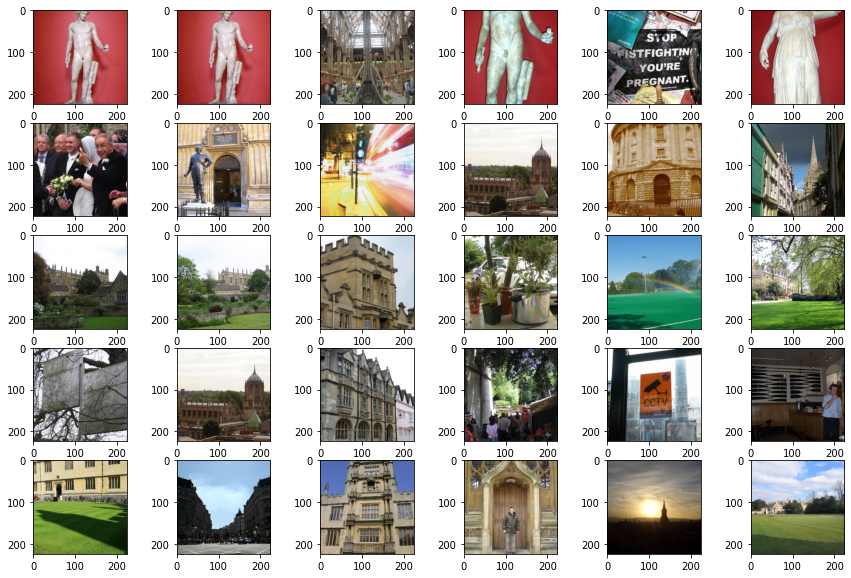

In [60]:
fix, ax = plt.subplots(5, 6, figsize=(15, 10))

for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  conv = conv.to(device)
  target_img = conv(samples[i].to(device))
  targetID = ind[i]
  dist, indices = calculate_distances(target_img, targetID, normalized)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())

**Comment:**

>- Features extracted by CLIP model are not well suited for ranking images.

### Regional Max-Pooling

In [62]:
from torchvision import datasets, transforms, models

input_resolution = 800
transformation = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/oxbuild_images/", transform=preprocess)

In [63]:
dsets

Dataset ImageFolder
    Number of datapoints: 5063
    Root location: /content/gdrive/My Drive/oxbuild_images/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [64]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

In [65]:
import math
import torch.nn.functional as F

def rmac(x, L=5, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v

In [66]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

class MyModel2(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=(3, 3), bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)             #[1, 768, 257, 257]
    #logit = self.pooling(out)
    #logit /= torch.sum(logit)
    #Regional Max-Pooling
    output = torch.nn.functional.normalize(out, p=2.0, dim=1)
    output = rmac(output)
    return output

In [67]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [68]:
conv = MyModel2(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)

print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel2(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(3, 3), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [69]:
image, label = dsets[0]
print("Images shape: ", image.shape)

Images shape:  torch.Size([3, 224, 224])


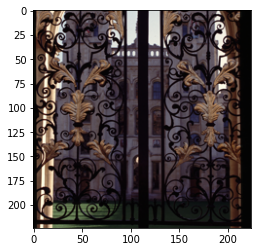

In [70]:
plt.imshow(image.permute(1, 2, 0).detach().numpy())

In [71]:
conv = conv.eval()
image = image.unsqueeze(0)
print(image.shape)
target_img = conv(image)
target_img.shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 768, 1, 1])

In [72]:
def preconvfeat(dataloader):
    conv_features = [] 
    imgs = []
    for data in dataloader:
        input, label = data
        with torch.no_grad():
          for i in range(input.shape[0]):
            img = input[i].to(device)
            img = img.unsqueeze(0)
            x = conv(img)
            x = x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-12).expand_as(x)
            imgs.append(img)
            conv_features.append(x.cpu().detach().numpy())
    
    return conv_features, imgs

In [73]:
conv = conv.to(device)
features, images = preconvfeat(data_loader)

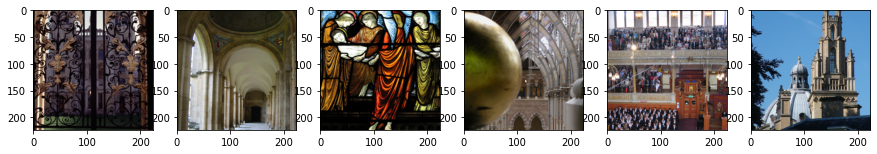

In [74]:
dist, indices = calculate_distances(target_img, 0, features)

ret_imgs = get_similar(images, indices)
fix, ax = plt.subplots(1, 6, figsize=(15, 10))

ax[0].imshow(image[0].permute(1, 2, 0).detach().numpy())
for i in range(0, 5):
  ax[i+1].imshow(ret_imgs[i][0].permute(1, 2, 0).cpu().detach().numpy())


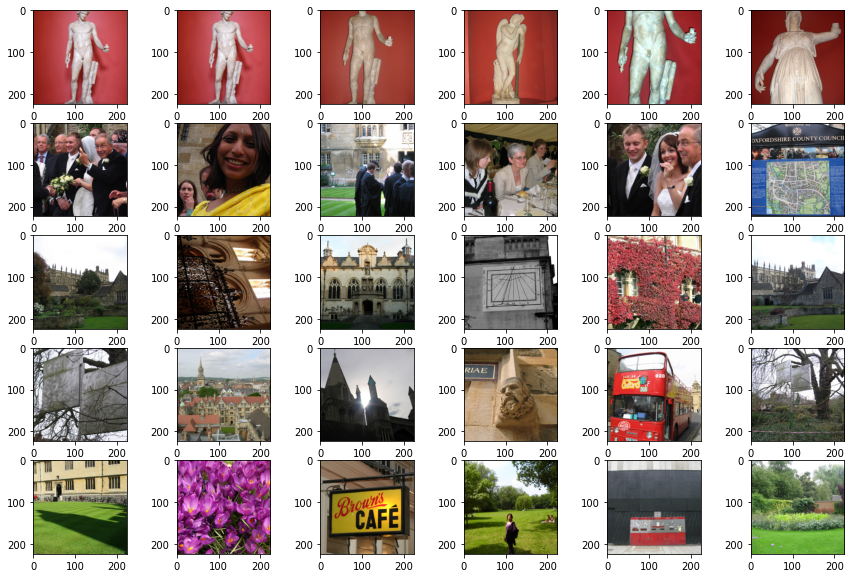

In [75]:
#samples, ind = generate_samples(dsets, 5)
fix, ax = plt.subplots(5, 6, figsize=(15, 10))
conv = conv.cpu()
for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  target_img = conv(samples[i])
  targetID = ind[i]
  dist, indices = calculate_distances(target_img, targetID, features)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())

In [76]:
#Cosine similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def calculate_cos_similarity(target, targetID, conv_features, nbr = 5):
  distances = []
  for i, img_conv in enumerate(conv_features):
    distance = cos(target.cpu(), torch.from_numpy(img_conv))
    if i != targetID: 
      distances.append(distance)

  indices = np.argsort(distances)[:nbr]
  return distances, indices

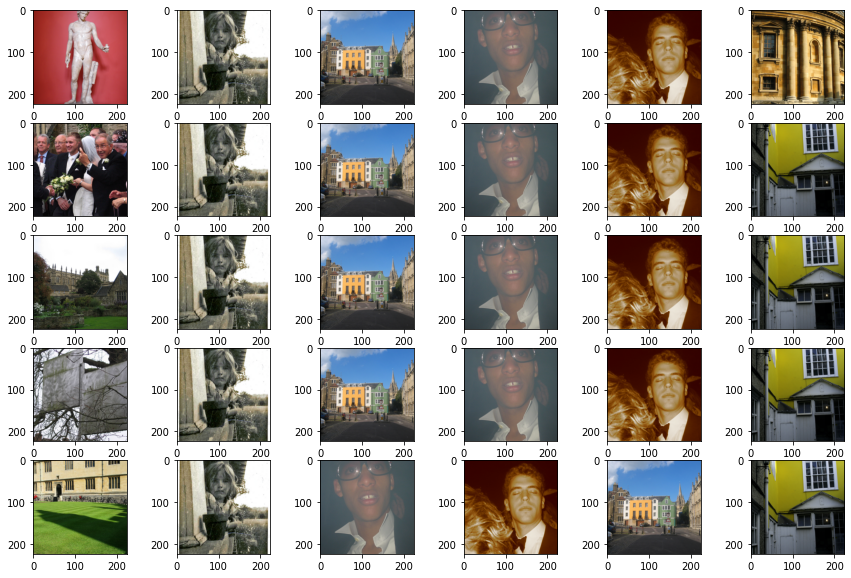

In [77]:
fix, ax = plt.subplots(5, 6, figsize=(15, 10))
conv = conv.cpu()
for i in range(0, 5):
  ax[i][0].imshow(samples[i][0].permute(1, 2, 0).cpu().detach().numpy())
  target_img = conv(samples[i])
  targetID = ind[i]
  dist, indices = calculate_cos_similarity(target_img, targetID, features)
  ret_imgs = get_similar(images, indices)
  for j in range(0, 5):
    ax[i][j+1].imshow(ret_imgs[j][0].permute(1, 2, 0).cpu().detach().numpy())